# Adding lightcurve effects to LSST Solar System Simulations
By Jamie Robinson

LSST SSSC Sprint June 2022

This notebook demonstrates the work I did at the Sprint. I wanted to add changes in asteroid brightness due to rotation and also the longer term changes of aspect angle that leads to shifts in brightness (on top of the already modelled distance and phase effects).

The asteroid is modelled as a triaxial ellipsoid rotating around its shortest axis
- axes a > b > c
- spin pole orientation (ecliptic longitude and latitude)
- rotation period and simple sinusoidal lightcurve

This shape model is applied to some asteroid from the simulated database. The database contains only sparse measurements as expected from the LSST cadence. Therefore we take the orbital elements and propagate using [sbpy open_orb](https://sbpy.readthedocs.io/en/latest/sbpy/data/orbit.html) to densely sample the asteroid positional coordinates.

These positions and and shape parameters are fed into the equations from [Fernández-Valenzuela 2022](https://arxiv.org/abs/2202.02374v1) and so a shift from the expected brightness due to lightcurve effects can be calculated for any observation made with LSST.

Based on the demo notebook by Juric et al., available from https://github.com/lsst-sssc/lsst-simulation

In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy import units as u
from astropy.coordinates import SkyCoord, GCRS
from sbpy.data import Orbit
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
from sbpy.photometry import HG
from astropy.table import QTable

In [4]:
# connect to database
pwd = open("/home/shared/sssc-db-pass.txt").read()
con = pg.connect(database="lsst_solsys", user="sssc", password=pwd, host="epyc.astro.washington.edu", port="5432")

### Select an asteroid from the database

In [5]:
# select some asteroids with a reasonable number of observations
df_ssobj = pd.read_sql("SELECT * FROM ssobjects where numobs>100 LIMIT 5", con)

In [6]:
df_ssobj

,ssobjectid,discoverysubmissiondate,firstobservationdate,arc,numobs,moid,moidtrueanomaly,moideclipticlongitude,moiddeltav,uh,...,yg12,yherr,yg12err,yh_yg12_cov,ychi2,yndata,maxextendedness,minextendedness,medianextendedness,flags
0,3369984299447,60203.374981,60196.374981,2582.7770,107,0.0,0.0,0.0,0.0,NaN,...,0.345189,0.087608,0.133565,0.010005,0.571543,7,0.0,0.0,0.0,0
1,5992863104062,60040.337008,60033.337008,3241.8570,145,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,10660550296725,59873.208132,59866.208132,3442.9424,116,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,14169511631100,59963.234375,59956.234375,3333.8674,289,0.0,0.0,0.0,0.0,NaN,...,0.105138,0.038684,0.090257,0.002581,0.736188,13,0.0,0.0,0.0,0
4,14369040295367,59865.265384,59858.265384,2975.7960,308,0.0,0.0,0.0,0.0,20.448154,...,0.185439,0.020225,0.025261,0.000455,0.792384,47,0.0,0.0,0.0,0


In [7]:
# Choose some object by its identifier "ssobjectid"
ssobjectid = 14169511631100

In [8]:
# Query to find the mpc designation identifier that corresponds to ssobjectid
qry = """
        SELECT 
            ssobjectid, mpcorb.mpcdesignation
        FROM
            ssobjects
            JOIN mpcorb USING (ssobjectid)
        WHERE
            ssobjectid='{}'
""".format(ssobjectid)
df = pd.read_sql(qry, con)

In [9]:
mpc_des = df.iloc[0]["mpcdesignation"]
mpc_des

'S100doiQa       '

### Retrieve observations

In [10]:
sql = """
    SELECT
        mpcdesignation, ssObjects.ssObjectId, mag, magSigma, filter, midPointTai as mjd, ra, decl, phaseAngle,
        topocentricDist, heliocentricDist, eclipticlambda, eclipticbeta,
        heliocentricx, heliocentricy, heliocentricz,
        topocentricx, topocentricy, topocentricz,
        heliocentricvx, heliocentricvy, heliocentricvz
    FROM
        mpcorb
        JOIN ssObjects USING (ssobjectid)
        JOIN diaSources USING (ssobjectid)
        JOIN ssSources USING (diaSourceid)
    WHERE
        mpcdesignation = '{}'
""".format(mpc_des)
df = pd.read_sql(sql, con)
# Distance correction to get reduced magnitude
df["cmag"] = df["mag"] - 5*np.log10(df["topocentricdist"]*df["heliocentricdist"])

In [11]:
# put obs in time order
df=df.sort_values("mjd")

In [12]:
df

,mpcdesignation,ssobjectid,mag,magsigma,filter,mjd,ra,decl,phaseangle,topocentricdist,...,heliocentricx,heliocentricy,heliocentricz,topocentricx,topocentricy,topocentricz,heliocentricvx,heliocentricvy,heliocentricvz,cmag
221,S100doiQa,14169511631100,21.747236,0.117441,i,59956.234375,135.646361,11.233583,8.342505,1.823498,...,-1.638028,2.090419,0.719361,-1.278892,1.250356,0.355236,-0.008227,-0.005801,-0.002566,18.244902
227,S100doiQa,14169511631100,21.791485,0.057519,i,59957.229467,135.464059,11.268270,7.959714,1.818000,...,-1.646204,2.084631,0.716803,-1.270909,1.250487,0.355243,-0.008204,-0.005831,-0.002576,18.295850
228,S100doiQa,14169511631100,21.711332,0.073672,z,59957.245586,135.460958,11.268851,7.953384,1.817913,...,-1.646336,2.084537,0.716761,-1.270777,1.250493,0.355243,-0.008204,-0.005831,-0.002576,18.215804
222,S100doiQa,14169511631100,21.821917,0.049366,r,59958.189412,135.284311,11.303410,7.587669,1.812944,...,-1.654069,2.079020,0.714325,-1.263301,1.250825,0.355345,-0.008182,-0.005859,-0.002586,18.332467
231,S100doiQa,14169511631100,21.917894,0.046935,r,59958.189858,135.284238,11.303432,7.587493,1.812941,...,-1.654073,2.079018,0.714324,-1.263298,1.250825,0.355345,-0.008182,-0.005859,-0.002586,18.428446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,S100doiQa,14169511631100,22.553791,0.043438,g,63268.088620,108.756170,17.076115,9.944378,1.848784,...,-1.282065,2.297494,0.813358,-0.568254,1.673430,0.542880,-0.009096,-0.004531,-0.002122,19.019655
277,S100doiQa,14169511631100,22.459470,0.034845,g,63268.177852,108.740690,17.079102,9.977975,1.849339,...,-1.282876,2.297089,0.813168,-0.567963,1.674059,0.543135,-0.009095,-0.004534,-0.002123,18.924694
278,S100doiQa,14169511631100,22.048769,0.039528,r,63268.193938,108.737908,17.079614,9.984020,1.849440,...,-1.283023,2.297016,0.813134,-0.567912,1.674174,0.543181,-0.009094,-0.004534,-0.002123,18.513877
276,S100doiQa,14169511631100,22.643286,0.037484,g,63276.115874,107.612004,17.338086,12.743919,1.906033,...,-1.354484,2.260079,0.795958,-0.550504,1.734147,0.568016,-0.008946,-0.004790,-0.002213,19.044015


In [13]:
list(df)

['mpcdesignation',
 'ssobjectid',
 'mag',
 'magsigma',
 'filter',
 'mjd',
 'ra',
 'decl',
 'phaseangle',
 'topocentricdist',
 'heliocentricdist',
 'eclipticlambda',
 'eclipticbeta',
 'heliocentricx',
 'heliocentricy',
 'heliocentricz',
 'topocentricx',
 'topocentricy',
 'topocentricz',
 'heliocentricvx',
 'heliocentricvy',
 'heliocentricvz',
 'cmag']

In [14]:
# query to retrieve the HG12 phase curve parameters in all filters
ssoId = int(df["ssobjectid"].iloc[0])
qry = """SELECT uH, uG12, uHErr, uG12Err, uChi2,
                gH, gG12, gHErr, gG12Err, gChi2,
                rH, rG12, rHErr, rG12Err, rChi2,
                iH, iG12, iHErr, iG12Err, iChi2,
                zH, zG12, zHErr, zG12Err, zChi2,
                yH, yG12, yHErr, yG12Err, yChi2
        FROM ssObjects WHERE ssObjectId={}""".format(ssoId)

df_hg = pd.read_sql(qry, con)
df_hg

,uh,ug12,uherr,ug12err,uchi2,gh,gg12,gherr,gg12err,gchi2,...,zh,zg12,zherr,zg12err,zchi2,yh,yg12,yherr,yg12err,ychi2
0,None,None,None,None,None,18.362034,0.219264,0.011466,0.020526,1.318255,...,17.785637,0.24849,0.028324,0.042346,1.183112,17.742504,0.105138,0.038684,0.090257,0.736188


In [15]:
# choose some colours to represent the different filters
col_dict = {"u":"C0","g":"C2","r":"C3","i":"C5","z":"C6","y":"C7"}

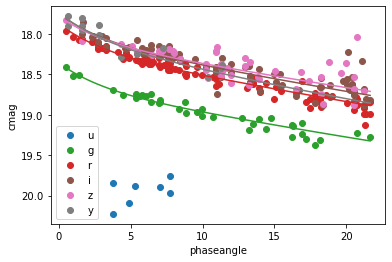

In [16]:
# plot the phase curve in multiple filters
x_plot = "phaseangle"
y_plot = "cmag"
c_plot = "filter"
df_plot = df

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

alpha = np.linspace(np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])) * u.deg

for f in col_dict.keys():
    _df_plot = df_plot[df_plot["filter"]==f]
    x=ax1.scatter(_df_plot[x_plot],_df_plot[y_plot], c= col_dict[f], label = f)
    
    h = "{}h".format(f)
    g12 = "{}g12".format(f)
    
    try:
        model = HG(H = df_hg[h] * u.mag, G = df_hg[g12])
    except:
        continue
        
    ax1.plot(alpha,model(alpha), c= col_dict[f])
                            
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()
ax1.legend()

plt.show()

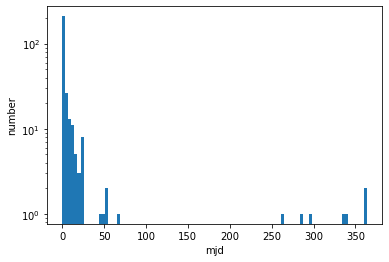

In [17]:
# what is the typical time difference between observations?

x_plot = "mjd"
df_plot = df.sort_values(x_plot) # make sure df is in time order...
bins = 100

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.hist(np.diff(df_plot[x_plot]),bins = bins, log = True)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number")

plt.show()

### Define some physical properties of our asteroid shape and rotation model

In [18]:
# calculate the spherical radius of the asteroid, given its absolute magnitude from the simulated database
C = 1330 # km
albedo = 0.15 # pick a typical asteroid albedo
abs_mag = df_hg.iloc[0]["rh"]
radius = 0.5*((C/np.sqrt(albedo)) * (10**(-0.2*abs_mag))) 
print("radius = {} km".format(radius))

radius = 0.4556819391654253 km


In [19]:
print("circular area = {} km^2".format(np.pi*radius*radius))

circular area = 0.6523392413946846 km^2


In [20]:
volume = (4.0/3.0)*np.pi*(radius**3.0)
print("volume = {} km^3".format(volume))

volume = 0.3963456140165764 km^3


In [21]:
def ellipsoid_axes(V,b_a,c_a):
    """
    Find the axes of an ellipsoid given a volume V and axes ratios.
    b_a is the b/a ratio
    c_a is the c/a ratio
    """
    a = (((3.0*V)/(4.0*np.pi)) * (1.0/b_a) *(1.0/c_a))**(1.0/3.0)
    b = b_a * a
    c = c_a * a
    return a,b,c

In [22]:
# define the triaxial ellipsoid axes
a,b,c = ellipsoid_axes(volume,0.75,0.5)
print(a,b,c)
print("volume = {} km^3".format((4.0/3.0)*np.pi*a*b*c))

0.6319044200766154 0.4739283150574616 0.3159522100383077
volume = 0.3963456140165764 km^3


In [23]:
# set rotational properties
period = 5.0/24 # rotation period (days)
t0 = 0 # reference time for lightcurve phase
lambda_pole = 0 # spin pole ecliptic longitude
beta_pole = np.pi/2.0 # spin pole ecliptic latitude

### Resample the sparse observations by propagating orbit with sbpy & oorb

In [24]:
# get the orbital elements from the database

sql = """
    SELECT
        *
    FROM
        mpcorb
    WHERE
        mpcdesignation = '{}'
""".format(mpc_des)
df_orb = pd.read_sql(sql, con)
df_orb.head()

,mpcdesignation,mpcnumber,ssobjectid,mpch,mpcg,epoch,tperi,peri,node,incl,...,arc,arcstart,arcend,rms,pertsshort,pertslong,computer,flags,fulldesignation,lastincludedobservation
0,S100doiQa,0,14169511631100,18.03,0.15,54800.0,51911.34966,339.31535,222.04643,3.59192,...,None,None,None,None,None,None,None,0,2011 S100doiQ,None


In [25]:
list(df_orb)

['mpcdesignation',
 'mpcnumber',
 'ssobjectid',
 'mpch',
 'mpcg',
 'epoch',
 'tperi',
 'peri',
 'node',
 'incl',
 'e',
 'n',
 'q',
 'uncertaintyparameter',
 'reference',
 'nobs',
 'nopp',
 'arc',
 'arcstart',
 'arcend',
 'rms',
 'pertsshort',
 'pertslong',
 'computer',
 'flags',
 'fulldesignation',
 'lastincludedobservation']

In [26]:
# Calculate some extra orbital elements
df_orb["a"] = df_orb["q"]/(1.0 - df_orb["e"])
df_orb["P"] = df_orb["a"]**(3.0/2.0) # orbital period in years
df_orb["n"] = 360.0 / (df_orb["P"] * 365.25) # mean motion in deg/day
df_orb["M"] = (df_orb["n"] * (df_orb["epoch"] - df_orb["tperi"])) % 360 # angles must be in correct range otherwise sbpy/pyoorb freak out
df_orb[["a","P","n","M"]]

,a,P,n,M
0,2.761968,4.590162,0.214726,260.267776


In [27]:
# rename columns for consistency
df_orb = df_orb.rename(columns={"node":"Omega","peri":"w"})

In [28]:
df_orb[["a","e","incl","Omega","w","M"]]

,a,e,incl,Omega,w,M
0,2.761968,0.01803,3.59192,222.04643,339.31535,260.267776


In [29]:
# create an sbpy oorb object from dataframe via QTable
tab = QTable.from_pandas(df_orb[["a","e","incl","Omega","w","M"]], units={'a': u.au, 'incl': u.deg, 'Omega': u.deg, 'w': u.deg, 'M': u.deg})
orbit = Orbit.from_table(tab)

In [30]:
# oorb requires certain extra fields
orbit["epoch"] = Time(Time(df_orb["epoch"], format="mjd").jd, format = "jd")
orbit["targetname"] = np.array(df_orb["ssobjectid"]).astype(str)
orbit["H"] = df_orb["mpch"] * u.mag
orbit["G"] = df_orb["mpcg"] * u.dimensionless_unscaled

In [31]:
orbit

<QTable length=1>
        a             e      incl    Omega   ...   targetname      H       G   
        AU                   deg      deg    ...                  mag          
     float64       float64 float64  float64  ...     str21      float64 float64
------------------ ------- ------- --------- ... -------------- ------- -------
2.7619682882369117 0.01803 3.59192 222.04643 ... 14169511631100   18.03    0.15

In [32]:
# define a set of JD times to propagate the orbital elements to
N=1000
times = Time(Time(np.linspace(np.amin(df["mjd"]),np.amax(df["mjd"]),N), format = "mjd").jd, format = "jd")
times[0]

<Time object: scale='utc' format='jd' value=2459956.7343750293>

In [33]:
# create an empty dataframe to hold resampled observations
df_dense = pd.DataFrame()
df_dense["mjd"] = times.mjd

In [34]:
# propagate the orbit forward in time.
# probably a better way to do this but I can't get oo_propagate to work with a Time list right now
# see: https://github.com/NASA-Planetary-Science/sbpy/issues/341

df_pos = pd.DataFrame() # empty dataframe to hold cartesian coordinates

for i in range(len(times)):
    print(i)
    prop_elem = orbit.oo_propagate(times[i]) # propagate the orbit to the selected time step
    del prop_elem.table["orbtype"] # orbtype is added as int, sbpy freaks out so delete the orbtype and then _to_oo works it out
    print("propagate")
    statevec = prop_elem.oo_transform('CART') # transform from orbital elements to cartesian
    print("transform")
    
    # append new cartesian coordinates to the dataframe
    _df_statevec = statevec.table.to_pandas()
    df_pos = pd.concat((df_pos,_df_statevec))
        
df_pos.reset_index(drop=True, inplace=True)

0
propagate
transform
1
propagate
transform
2
propagate
transform
3
propagate
transform
4
propagate
transform
5
propagate
transform
6
propagate
transform
7
propagate
transform
8
propagate
transform
9
propagate
transform
10
propagate
transform
11
propagate
transform
12
propagate
transform
13
propagate
transform
14
propagate
transform
15
propagate
transform
16
propagate
transform
17
propagate
transform
18
propagate
transform
19
propagate
transform
20
propagate
transform
21
propagate
transform
22
propagate
transform
23
propagate
transform
24
propagate
transform
25
propagate
transform
26
propagate
transform
27
propagate
transform
28
propagate
transform
29
propagate
transform
30
propagate
transform
31
propagate
transform
32
propagate
transform
33
propagate
transform
34
propagate
transform
35
propagate
transform
36
propagate
transform
37
propagate
transform
38
propagate
transform
39
propagate
transform
40
propagate
transform
41
propagate
transform
42
propagate
transform
43
propagate
transfor

propagate
transform
349
propagate
transform
350
propagate
transform
351
propagate
transform
352
propagate
transform
353
propagate
transform
354
propagate
transform
355
propagate
transform
356
propagate
transform
357
propagate
transform
358
propagate
transform
359
propagate
transform
360
propagate
transform
361
propagate
transform
362
propagate
transform
363
propagate
transform
364
propagate
transform
365
propagate
transform
366
propagate
transform
367
propagate
transform
368
propagate
transform
369
propagate
transform
370
propagate
transform
371
propagate
transform
372
propagate
transform
373
propagate
transform
374
propagate
transform
375
propagate
transform
376
propagate
transform
377
propagate
transform
378
propagate
transform
379
propagate
transform
380
propagate
transform
381
propagate
transform
382
propagate
transform
383
propagate
transform
384
propagate
transform
385
propagate
transform
386
propagate
transform
387
propagate
transform
388
propagate
transform
389
propagate
transf

/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
436
propagate
transform
437
propagate
transform
438


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
439
propagate
transform
440


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
441
propagate
transform
442
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

transform
443
propagate
transform
444
propagate
transform
445


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
446
propagate
transform
447
propagate
transform
448

/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con


propagate
transform
449
propagate
transform
450


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
451
propagate
transform
452
propagate
transform
453

/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con


propagate
transform
454
propagate
transform
455
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
456
propagate
transform
457
propagate
transform
458
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

459
propagate
transform
460
propagate
transform
461


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
462
propagate
transform
463
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
464
propagate
transform
465
propagate
transform
466


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
467
propagate
transform
468
propagate
transform
469


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
470
propagate
transform
471
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
472
propagate
transform
473
propagate
transform
474


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
475
propagate
transform
476
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

477
propagate
transform
478
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

479
propagate
transform
480
propagate
transform
481


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
482
propagate
transform
483
propagate
transform
484


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
485
propagate
transform
486


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
487
propagate
transform
488
propagate
transform
489
propagate
transform
490
propagate
transform
491
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

492
propagate
transform
493
propagate
transform
494
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
495
propagate
transform
496
propagate
transform
497


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
498
propagate
transform
499
propagate
transform
500
propagate
transform
501
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

transform
502
propagate
transform
503
propagate
transform
504
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

transform
505
propagate
transform
506
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

507
propagate
transform
508
propagate
transform
509


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
510
propagate
transform
511


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
512
propagate
transform
513
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
514
propagate
transform
515


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
516
propagate
transform
517
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

transform
518
propagate
transform
519
propagate
transform
520
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

transform
521
propagate
transform
522
propagate
transform
523


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)


propagate
transform
524


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
525
propagate
transform
526
propagate
transform
527
propagate
transform
528


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
529
propagate
transform
530
propagate
transform
531


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
532
propagate
transform
533


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
534
propagate
transform
535
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

transform
536
propagate
transform
537
propagate
transform
538


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
539
propagate
transform
540


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
541
propagate
transform
542
propagate
transform
543
propagate
transform
544
propagate
transform
545


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
546
propagate
transform
547
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

transform
548
propagate
transform
549
propagate
transform
550


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
551
propagate
transform
552


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
553
propagate
transform
554
propagate
transform
555


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
556
propagate
transform
557
propagate
transform
558
propagate
transform
559
propagate
transform
560
propagate
transform
561


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
562
propagate
transform
563
propagate
transform
564


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
565
propagate
transform
566
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

transform
567
propagate
transform
568
propagate
transform
569


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
570
propagate
transform
571


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
572
propagate
transform
573
propagate
transform
574
propagate
transform
575
propagate
transform
576


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
577
propagate
transform
578
propagate
transform
579
propagate
transform
580


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
581
propagate
transform
582
propagate
transform
583


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
584
propagate
transform
585
propagate
transform
586
propagate
transform
587


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
588
propagate
transform
589
propagate
transform
590


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
591
propagate
transform
592


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
593
propagate
transform
594
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

transform
595
propagate
transform
596


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
597
propagate
transform
598


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
599
propagate
transform
600


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
601
propagate
transform
602
propagate


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

transform
603
propagate
transform
604
propagate
transform
605


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)


propagate
transform
606
propagate
transform
607


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
608
propagate
transform
609


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
610
propagate
transform
611


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
612
propagate
transform
613


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
614
propagate
transform
615


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
616
propagate
transform
617


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
618
propagate
transform
619


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
620
propagate
transform
621


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
622
propagate
transform
623


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
624
propagate
transform
625


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
626
propagate
transform
627


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
628
propagate
transform
629


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
630
propagate
transform
631


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
632
propagate
transform
633
propagate
transform
634


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
635
propagate
transform
636


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
637
propagate
transform
638


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
639
propagate
transform
640


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
641
propagate
transform
642


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
643
propagate
transform
644
propagate
transform
645


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
646
propagate
transform
647
propagate
transform
648
propagate
transform
649


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
650
propagate
transform
651
propagate
transform
652


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.cond

propagate
transform
653
propagate
transform
654
propagate
transform
655


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
656
propagate
transform
657
propagate
transform
658


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
659
propagate
transform
660


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
661
propagate
transform
662


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
663
propagate
transform
664


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
665
propagate
transform
666


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
667
propagate
transform
668


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
669
propagate
transform
670


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
671
propagate
transform
672
propagate
transform
673


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
674
propagate
transform
675


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
676
propagate
transform
677
propagate
transform
678


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
679
propagate
transform
680


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
681
propagate
transform
682


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
683
propagate
transform
684
propagate
transform
685


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
686
propagate
transform
687
propagate
transform
688
propagate
transform
689


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
690
propagate
transform
691


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
692
propagate
transform
693
propagate
transform
694


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
695
propagate
transform
696


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
697
propagate
transform
698
propagate
transform
699


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
700
propagate
transform
701
propagate
transform
702


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
703
propagate
transform
704
propagate
transform
705


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
706
propagate
transform
707
propagate
transform
708


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
709
propagate
transform
710
propagate
transform
711


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
712
propagate
transform
713
propagate
transform
714


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
715
propagate
transform
716
propagate
transform
717


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
718
propagate
transform
719


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
720
propagate
transform
721


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
722
propagate
transform
723


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
724
propagate
transform
725
propagate
transform
726


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
727
propagate
transform
728


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
729
propagate
transform
730


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
731
propagate
transform
732


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
733
propagate
transform
734


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
735
propagate
transform
736
propagate
transform
737


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
738
propagate
transform
739
propagate
transform
740


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
741
propagate
transform
742
propagate
transform
743


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
744
propagate
transform
745


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
746
propagate
transform
747


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
748
propagate
transform
749
propagate
transform
750


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
751
propagate
transform
752
propagate
transform
753


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
754
propagate
transform
755


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
756
propagate
transform
757


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
758
propagate
transform
759
propagate
transform
760


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
761
propagate
transform
762


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
763
propagate
transform
764


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
765
propagate
transform
766
propagate
transform
767


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
768
propagate
transform
769
propagate
transform
770


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
771
propagate
transform
772
propagate
transform
773


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
774
propagate
transform
775
propagate
transform
776


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
777
propagate
transform
778


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
779
propagate
transform
780


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
781
propagate
transform
782


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
783
propagate
transform
784
propagate
transform
785


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
786
propagate
transform
787
propagate
transform
788


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
789
propagate
transform
790
propagate
transform
791


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
792
propagate
transform
793
propagate
transform
794


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
795
propagate
transform
796


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
797
propagate
transform
798


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
799
propagate
transform
800


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
801
propagate
transform
802
propagate
transform
803


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
804
propagate
transform
805
propagate
transform
806


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
807
propagate
transform
808
propagate
transform
809


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
810
propagate
transform
811


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
812
propagate
transform
813
propagate
transform
814


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
815
propagate
transform
816
propagate
transform
817


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
818
propagate
transform
819


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
820
propagate
transform
821


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
822
propagate
transform
823


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
824
propagate
transform
825
propagate
transform
826


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
827
propagate
transform
828


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
829
propagate
transform
830


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
831
propagate
transform
832
propagate
transform
833


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
834
propagate
transform
835
propagate
transform
836


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
837
propagate
transform
838


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
839
propagate
transform
840


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
841
propagate
transform
842
propagate
transform
843


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
844
propagate
transform
845


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
846
propagate
transform
847
propagate
transform
848


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
849
propagate
transform
850
propagate
transform
851
propagate
transform
852


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
853
propagate
transform
854
propagate
transform
855


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
856
propagate
transform
857


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
858
propagate
transform
859


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
860
propagate
transform
861
propagate
transform
862


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
863
propagate
transform
864
propagate
transform
865


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
866
propagate
transform
867


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
868
propagate
transform
869


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
870
propagate
transform
871


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
872
propagate
transform
873
propagate
transform
874


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
875
propagate
transform
876
propagate
transform
877


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
878
propagate
transform
879
propagate
transform
880


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
881
propagate
transform
882


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
883
propagate
transform
884
propagate
transform
885


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
886
propagate
transform
887
propagate
transform
888


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
889
propagate
transform
890
propagate
transform
891
propagate
transform
892


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
893
propagate
transform
894
propagate
transform
895


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
896
propagate
transform
897


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
898
propagate
transform
899
propagate
transform
900


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
901
propagate
transform
902
propagate
transform
903


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
904
propagate
transform
905
propagate
transform
906


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
907
propagate
transform
908
propagate
transform
909


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
910
propagate
transform
911
propagate
transform
912


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
913
propagate
transform
914


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
915
propagate
transform
916


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
917
propagate
transform
918


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
919
propagate
transform
920


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
921
propagate
transform
922
propagate
transform
923


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
924
propagate
transform
925


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
926
propagate
transform
927
propagate
transform
928


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
929
propagate
transform
930
propagate
transform
931


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
932
propagate
transform
933


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
934
propagate
transform
935
propagate
transform
936


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
937
propagate
transform
938
propagate
transform
939


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
940
propagate
transform
941


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
942
propagate
transform
943


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
944
propagate
transform
945


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
946
propagate
transform
947
propagate
transform
948


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
949
propagate
transform
950
propagate
transform
951


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
952
propagate
transform
953
propagate
transform
954


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
955
propagate
transform
956


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
957
propagate
transform
958
propagate
transform
959


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
960
propagate
transform
961
propagate
transform
962


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
963
propagate
transform
964


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
965
propagate
transform
966
propagate
transform
967


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
968
propagate
transform
969


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
970
propagate
transform
971
propagate
transform
972


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
973
propagate
transform
974


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
975
propagate
transform
976


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
977
propagate
transform
978
propagate
transform
979


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
980
propagate
transform
981


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
982
propagate
transform
983
propagate
transform
984


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
985
propagate
transform
986
propagate
transform
987


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
988
propagate
transform
989
propagate
transform
990


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
991
propagate
transform
992


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
993
propagate
transform
994


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
995
propagate
transform
996
propagate
transform
997


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

propagate
transform
998
propagate
transform
999
propagate
transform


/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/jrob93/.con

In [35]:
df_pos

,id,x,y,z,vx,vy,vz,orbtype,epoch,epoch_scale,H,G
0,14169511631100,-1.638560,2.203658,-0.171523,-0.008226,-0.006345,-0.000046,CART,2023-01-12 05:37:30.002534430,3.0,18.03,0.15
1,14169511631100,-1.665881,2.182309,-0.171664,-0.008148,-0.006449,-0.000038,CART,2023-01-15 13:43:04.479993324,3.0,18.03,0.15
2,14169511631100,-1.692939,2.160616,-0.171778,-0.008068,-0.006552,-0.000030,CART,2023-01-18 21:48:38.957452218,3.0,18.03,0.15
3,14169511631100,-1.719729,2.138579,-0.171865,-0.007987,-0.006654,-0.000022,CART,2023-01-22 05:54:13.434870880,3.0,18.03,0.15
4,14169511631100,-1.746246,2.116204,-0.171925,-0.007905,-0.006755,-0.000014,CART,2023-01-25 13:59:47.912329774,3.0,18.03,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...
995,14169511631100,-1.360761,2.386485,-0.168818,-0.008933,-0.005299,-0.000123,CART,2032-02-14 18:04:15.069185536,3.0,18.03,0.15
996,14169511631100,-1.390464,2.368612,-0.169216,-0.008868,-0.005412,-0.000115,CART,2032-02-18 02:09:49.546644430,3.0,18.03,0.15
997,14169511631100,-1.419946,2.350364,-0.169588,-0.008801,-0.005524,-0.000107,CART,2032-02-21 10:15:24.024103324,3.0,18.03,0.15
998,14169511631100,-1.449204,2.331745,-0.169933,-0.008733,-0.005635,-0.000099,CART,2032-02-24 18:20:58.501562219,3.0,18.03,0.15


### Use astropy coordinates to transform between all the coordinate systems

In [36]:
# define heliocentric cartesian coordinates
c_xyz_hel = SkyCoord(x=np.array(df_pos["x"]), 
             y=np.array(df_pos["y"]), 
             z=np.array(df_pos["z"]), 
             unit='AU', representation_type='cartesian', frame="heliocentrictrueecliptic")

In [37]:
# transform to heliocentric ecliptic coords
c_ecl_hel = c_xyz_hel.copy()
c_ecl_hel.representation_type = "spherical"

In [38]:
# transform to geocentric equatorial coords (times required to calculate Earth position)
with solar_system_ephemeris.set('jpl'): 
    c_eq_geo = c_xyz_hel.transform_to(GCRS(obstime=times))

/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 565 of "dubious year (Note 3)"
  ErfaWarning)
/home/jrob93/.conda/envs/jrob/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 565 of "dubious year (Note 4)"
  ErfaWarning)


In [39]:
# transform to geocentric cartesian coords
c_xyz_geo = c_eq_geo.copy()
c_xyz_geo.representation_type = "cartesian"

In [40]:
# transform from geo equatorial (ra, dec) to geo ecliptic (lon, lat)
c_ecl_geo = c_eq_geo.transform_to("geocentrictrueecliptic")

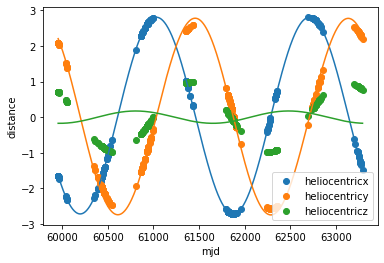

In [41]:
# plot the propagated cartesian positions against the database values

x_plot = "mjd"
y_plot1 = "heliocentricx"
y_plot2 = "heliocentricy"
y_plot3 = "heliocentricz"
df_plot = df

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.scatter(df_plot[x_plot],df_plot[y_plot1], label = y_plot1)
x=ax1.scatter(df_plot[x_plot],df_plot[y_plot2], label = y_plot2)
x=ax1.scatter(df_plot[x_plot],df_plot[y_plot3], label = y_plot3)

ax1.plot(times.mjd,c_xyz_hel.x)
ax1.plot(times.mjd,c_xyz_hel.y)
ax1.plot(times.mjd,c_xyz_hel.z)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("distance")
ax1.legend()

plt.show()

There are some deviations of x and y positions, probably due to slightly different reference frames and methods of propagating orbits.

There is something wrong with database z positions, will be fixed soon!

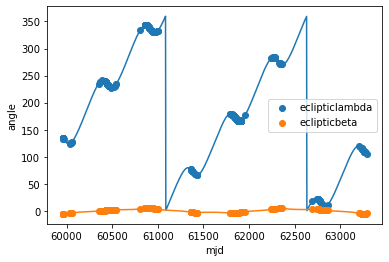

In [42]:
# the ecliptic coordinates look good!

x_plot = "mjd"
y_plot1 = "eclipticlambda"
y_plot2 = "eclipticbeta"
df_plot = df

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.scatter(df_plot[x_plot],df_plot[y_plot1], label = y_plot1)
x=ax1.scatter(df_plot[x_plot],df_plot[y_plot2], label = y_plot2)

ax1.plot(times.mjd,c_ecl_geo.lon.degree)
ax1.plot(times.mjd,c_ecl_geo.lat.degree)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("angle")
ax1.legend()

plt.show()

### Calculate asteroid aspect angle from ecliptic coordinates

In [43]:
def aspect_angle(lambda_obj, beta_obj, lambda_pole = 0, beta_pole = np.pi/2.0):
    """
    Calculate the aspect angle as a function of ecliptic coords of object and pole (radians)
    (Fernandez-Valenzuelae t al. 2022)
    """
    return (np.pi/2.0) - np.sin((np.sin(beta_obj)*np.sin(beta_pole)) + (np.cos(beta_obj)*np.cos(beta_pole)*np.cos(lambda_obj - lambda_pole)))

In [44]:
# calculate aspect angle for each observation
df["aspect(deg)"] = np.degrees(aspect_angle(np.radians(df["eclipticlambda"]),np.radians(df["eclipticbeta"]),
                                           lambda_pole, beta_pole))

In [45]:
# find the aspect angle but for the more dense & uniform sampled times
df_dense["aspect(deg)"] = np.degrees(aspect_angle(c_ecl_geo.lon.radian,c_ecl_geo.lat.radian))

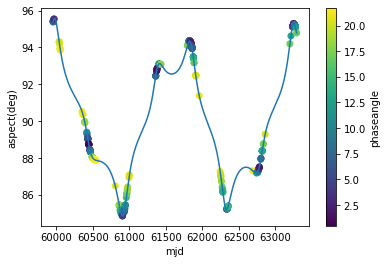

In [46]:
x_plot = "mjd"
y_plot = "aspect(deg)"
c_plot = "phaseangle"
df_plot = df
df_plot2 = df_dense

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1=ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot(df_plot2[x_plot],df_plot2[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

### Find the lightcurve amplitude as a function of aspect angle and asteroid shape

In [47]:
def lightcurve_amplitude(aspect_angle, a=1, b=0.75, c=0.5):
    """
    Calculate the lightcurve amplitude for a trixial ellipsoid of axis ratio a:b:c, as a function of aspect angle
    """
    X = 2.5*np.log10(a/b)
    Y = ((a*np.cos(aspect_angle))**2.0) + ((c*np.sin(aspect_angle))**2.0)
    Z = ((b*np.cos(aspect_angle))**2.0) + ((c*np.sin(aspect_angle))**2.0)
    return X - (1.25*np.log10(Y/Z))

In [48]:
lc_amp = lightcurve_amplitude(df["aspect(deg)"])
df["lc_amp(mag)"] = lc_amp

In [49]:
df_dense["lc_amp(mag)"] = lightcurve_amplitude(df_dense["aspect(deg)"])

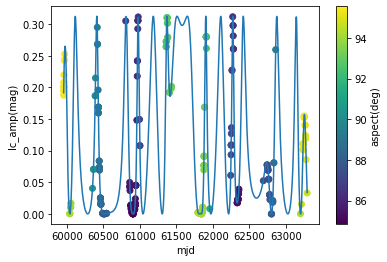

In [50]:
x_plot = "mjd"
y_plot = "lc_amp(mag)"
c_plot = "aspect(deg)"
df_plot = df
df_plot2 = df_dense

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1=ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot(df_plot2[x_plot],df_plot2[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

### find the projected asteroid area as a function of aspect angle and shape

In [51]:
def area_aspect(aspect_angle, a=1, b=0.75, c=0.5):
    """
    Calculate the projected areas of a triaxial ellipsoid as a function of aspect angle.
    The axes a,b,c should be in appropriate units of length to calculate absolute magnitude
    """
    area_min = np.pi*b*np.sqrt(((a*np.cos(aspect_angle))**2.0) + ((c*np.sin(aspect_angle))**2.0))
    area_max = np.pi*a*np.sqrt(((b*np.cos(aspect_angle))**2.0) + ((c*np.sin(aspect_angle))**2.0))
    area_avg = (area_max + area_min)/2.0
    return area_avg

In [52]:
# find the projected area of asteroid as a function of time
df["projected_area(km^2)"] = area_aspect(df['aspect(deg)'],a,b,c)

In [53]:
df_dense["projected_area(km^2)"] = area_aspect(df_dense['aspect(deg)'],a,b,c)

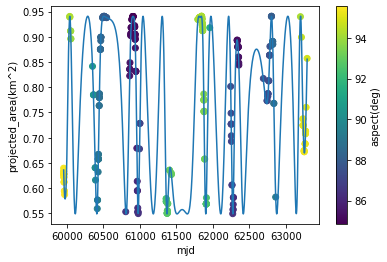

In [54]:
x_plot = "mjd"
y_plot = "projected_area(km^2)"
c_plot = "aspect(deg)"
df_plot = df
df_plot2 = df_dense

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1=ax1.scatter(df_plot[x_plot], df_plot[y_plot], c = df_plot[c_plot])
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot(df_plot2[x_plot],df_plot2[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

### find the change in absolute magnitude as projected area changes

In [55]:
delta_H = 2.5*np.log10((np.pi*radius*radius)/(df["projected_area(km^2)"]))
df["delta_H(mag)"] = delta_H

In [56]:
df_dense["delta_H(mag)"] = delta_H = 2.5*np.log10((np.pi*radius*radius)/(df_dense["projected_area(km^2)"]))

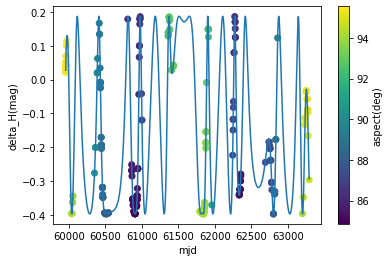

In [57]:
x_plot = "mjd"
y_plot = "delta_H(mag)"
c_plot = "aspect(deg)"
df_plot = df

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1=ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot(df_plot2[x_plot],df_plot2[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

### Calculate the rotational brightness variation

In [58]:
m_rot = (df["lc_amp(mag)"]/2.0) * np.sin((2*np.pi*(df["mjd"] - t0))/period) # assume simple sinusoidal lightcurve
df["m_rot(mag)"] = m_rot

In [59]:
df_dense["m_rot(mag)"] = (df_dense["lc_amp(mag)"]/2.0) * np.sin((2*np.pi*(df_dense["mjd"] - t0))/period)

### Add all rotation and shape effects to the observed brightness

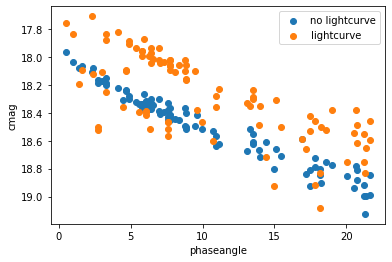

In [60]:
# the lightcurve effects leads to the apparition effect, distinct shifts in brightness with the seasons

x_plot = "phaseangle"
y_plot = "cmag"
y_plot1 = "delta_H(mag)"
y_plot2 = "m_rot(mag)"
df_plot = df[df["filter"]=="r"]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.scatter(df_plot[x_plot],df_plot[y_plot], label = "no lightcurve")
x=ax1.scatter(df_plot[x_plot],df_plot[y_plot] + df_plot[y_plot1] + df_plot[y_plot2], label = "lightcurve")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()
ax1.legend()

plt.show()

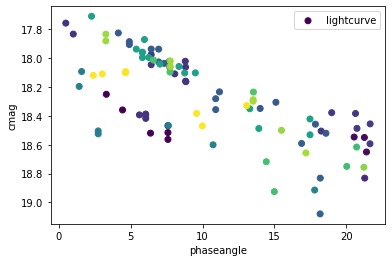

In [61]:
x_plot = "phaseangle"
y_plot = "cmag"
y_plot1 = "delta_H(mag)"
y_plot2 = "m_rot(mag)"
df_plot = df[df["filter"]=="r"]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.scatter(df_plot[x_plot],df_plot[y_plot] + df_plot[y_plot1] + df_plot[y_plot2], c = df_plot["mjd"], label = "lightcurve")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()
ax1.legend()

plt.show()

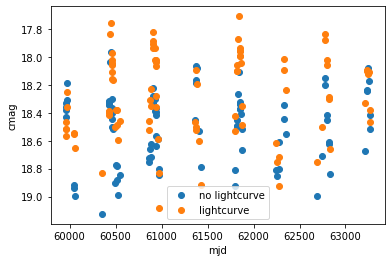

In [62]:
x_plot = "mjd"
y_plot = "cmag"
y_plot1 = "delta_H(mag)"
y_plot2 = "m_rot(mag)"
df_plot = df[df["filter"]=="r"]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.scatter(df_plot[x_plot],df_plot[y_plot], label = "no lightcurve")
x=ax1.scatter(df_plot[x_plot],df_plot[y_plot] + df_plot[y_plot1] + df_plot[y_plot2], label = "lightcurve")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()
ax1.legend()

plt.show()

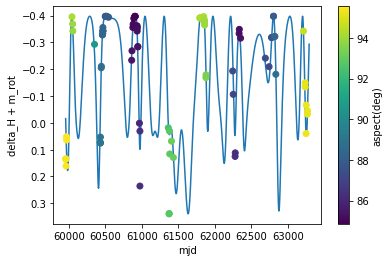

In [63]:
x_plot = "mjd"
y_plot1 = "delta_H(mag)"
y_plot2 = "m_rot(mag)"
c_plot = "aspect(deg)"
df_plot = df[df["filter"]=="r"]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1=ax1.scatter(df_plot[x_plot],df_plot[y_plot1] + df_plot[y_plot2], c = df_plot[c_plot], zorder=1)
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot(times.mjd,df_plot2[y_plot1] + df_plot2[y_plot2], zorder = 0)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("delta_H + m_rot")
ax1.invert_yaxis()

plt.show()

There are some deviations of the shifted database brightnesses from our model which we have propagated ourselves. This is probably something to do with the problems with z-components as mentioned above.